# Pruning Results Analysis

This notebook analyzes the results from iterative and window pruning experiments.

In [20]:
import json
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Configuration
DEVICE = '3'  # Change this to use different GPU device
os.environ['CUDA_VISIBLE_DEVICES'] = DEVICE
print(f'Using GPU device: {DEVICE}')

# Add project root to path
sys.path.append('../..')
from src.pruninghealing.utils import load_model_and_tokenizer, get_model_layers

Using GPU device: 3


## Load Latest Experiment Logs

In [50]:
def load_experiment_logs(workspace_dir="../../workspace"):
    """Load only the latest experiment logs from workspace"""
    logs = {}
    
    # Find experiment directories
    for exp_type in ["iterative_pruning", "window_pruning"]:
        exp_dir = os.path.join(workspace_dir, exp_type)
        if os.path.exists(exp_dir):
            # Find all run directories
            run_dirs = [d for d in os.listdir(exp_dir) if d.startswith("run_")]
            if run_dirs:
                # Get the latest run (highest number)
                latest_run = max(run_dirs, key=lambda x: int(x.split("_")[1]))
                log_file = os.path.join(exp_dir, latest_run, "experiment_log.json")
                
                if os.path.exists(log_file):
                    exp_name = exp_type.replace("_pruning", "")
                    with open(log_file, 'r') as f:
                        logs[exp_name] = json.load(f)
    
    return logs

# Load logs
logs = load_experiment_logs()
print(f"Found {len(logs)} experiment logs:")
for key in logs.keys():
    print(f"  - {key}")

Found 2 experiment logs:
  - iterative
  - window


## Pruning Progression Visualization

In [51]:
def extract_perplexity_data(logs):
    """Extract perplexity data from logs"""
    data = []
    
    for exp_name, log_entries in logs.items():
        for entry in log_entries:
            ppl = entry.get('perplexity')
            if ppl is not None and ppl > 0:
                data.append({
                    'experiment': exp_name,
                    'step': entry.get('step', 0),
                    'action': entry.get('action', 'unknown'),
                    'perplexity': ppl,
                    'layers_remaining': entry.get('layers_remaining', entry.get('layers_total')),
                    'layers_removed': entry.get('layers_removed')
                })
    
    return pd.DataFrame(data)

# Extract perplexity data
ppl_data = extract_perplexity_data(logs)
print(f"Extracted {len(ppl_data)} perplexity measurements")
if len(ppl_data) > 0:
    print("\nFirst few entries:")
    print(ppl_data.head())
    print("\nExperiments found:", ppl_data['experiment'].unique().tolist())
    print("\nActions per experiment:")
    for exp in ppl_data['experiment'].unique():
        actions = ppl_data[ppl_data['experiment'] == exp]['action'].unique()
        print(f"  {exp}: {actions.tolist()}")
else:
    print("No perplexity data found. Let's examine the log structure:")
    for exp_name, log_entries in logs.items():
        print(f"\n{exp_name}:")
        for i, entry in enumerate(log_entries[:3]):  # Show first 3 entries
            print(f"  Entry {i}: {entry}")
        if len(log_entries) > 3:
            print(f"  ... and {len(log_entries)-3} more entries")

Extracted 10 perplexity measurements

First few entries:
  experiment  step    action  perplexity  layers_remaining layers_removed
0  iterative     0  baseline  528.258179              32.0           None
1  iterative     1     prune  558.031921              31.0           None
2  iterative     1     train  557.320557               NaN           None
3  iterative     2     prune  600.258728              30.0           None
4  iterative     2     train  599.474426               NaN           None

Experiments found: ['iterative', 'window']

Actions per experiment:
  iterative: ['baseline', 'prune', 'train']
  window: ['baseline', 'prune', 'train']


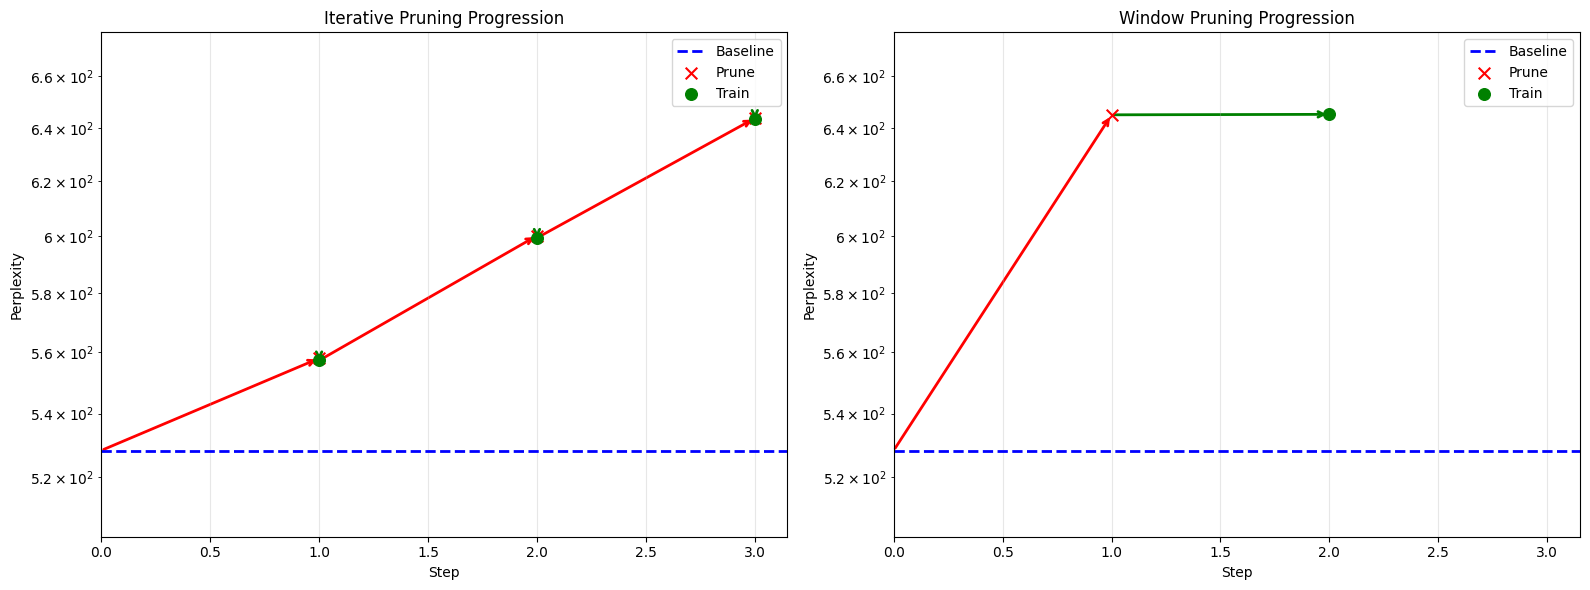

In [52]:

if len(ppl_data) == 0:
    print("No perplexity data to plot!")
else:
    experiments = ppl_data['experiment'].unique()
    fig, axes = plt.subplots(1, len(experiments), figsize=(8*len(experiments), 6), squeeze=False)
    axes = axes[0]  # Unpack for 1D indexing

    # Найдем общие границы осей
    min_step = ppl_data['step'].min()
    max_step = ppl_data['step'].max()
    min_ppl = ppl_data['perplexity'].min()
    max_ppl = ppl_data['perplexity'].max()

    for idx, exp_name in enumerate(experiments):
        exp_data = ppl_data[ppl_data['experiment'] == exp_name].sort_values('step')
        ax = axes[idx]

        # Get baseline
        baseline_data = exp_data[exp_data['action'] == 'baseline']
        if len(baseline_data) > 0:
            baseline = baseline_data['perplexity'].iloc[0]
            baseline_step = baseline_data['step'].iloc[0]
            # Plot baseline as horizontal line
            ax.axhline(y=baseline, color='blue', linestyle='--', linewidth=2, label='Baseline')

            # Plot progression with vectors
            prev_step = baseline_step
            prev_ppl = baseline

            # Для легенды: не дублировать элементы
            added = {'prune': False, 'train': False}

            for _, row in exp_data.iterrows():
                if row['action'] == 'baseline':
                    continue

                # Draw vector from previous point to current
                if row['action'] == 'prune':
                    color = 'red'
                    marker = 'x'
                else:  # train
                    color = 'green'
                    marker = 'o'

                ax.annotate('', xy=(row['step'], row['perplexity']),
                            xytext=(prev_step, prev_ppl),
                            arrowprops=dict(arrowstyle='->', color=color, lw=2),
                            zorder=1)

                # Добавляем подпись только один раз для каждого типа
                label = row['action'].capitalize() if not added[row['action']] else None
                ax.scatter(row['step'], row['perplexity'], color=color, s=70,
                           marker=marker, label=label, zorder=5)
                added[row['action']] = True

                prev_step = row['step']
                prev_ppl = row['perplexity']

        # Настройки осей
        ax.set_xlabel('Step')
        ax.set_ylabel('Perplexity')
        ax.set_title(f'{exp_name.title()} Pruning Progression')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

        # Синхронизируем пределы осей
        ax.set_xlim(left=0, right=max_step + 0.05*(max_step - min_step))
        ax.set_ylim(bottom=min_ppl*0.95, top=max_ppl*1.05)

        ax.legend()

    plt.tight_layout()
    plt.show()

## Summary Statistics

In [27]:
if len(ppl_data) > 0:
    # Summary by experiment
    print("Experiment Summary:")
    for exp_name in ppl_data['experiment'].unique():
        exp_data = ppl_data[ppl_data['experiment'] == exp_name]
        baseline_data = exp_data[exp_data['action'] == 'baseline']
        
        if len(baseline_data) > 0:
            baseline = baseline_data['perplexity'].iloc[0]
            final = exp_data[exp_data['step'] == exp_data['step'].max()]['perplexity'].iloc[0]
            
            print(f"\n{exp_name.title()}:")
            print(f"  Baseline: {baseline:.2f}")
            print(f"  Final: {final:.2f}")
            print(f"  Change: {((final - baseline) / baseline * 100):+.1f}%")
            
            # Show progression
            print("  Progression:")
            for _, row in exp_data.sort_values('step').iterrows():
                print(f"    Step {row['step']} ({row['action']}): {row['perplexity']:.2f}")
else:
    print("No perplexity data available for statistics.")

Experiment Summary:

Iterative:
  Baseline: 528.26
  Final: 528.26
  Change: +0.0%
  Progression:
    Step 0 (baseline): 528.26

Window:
  Baseline: 528.26
  Final: 59246.78
  Change: +11115.5%
  Progression:
    Step 0 (baseline): 528.26
    Step 1 (prune): 66974.62
    Step 2 (train): 59246.78


## Model Comparison

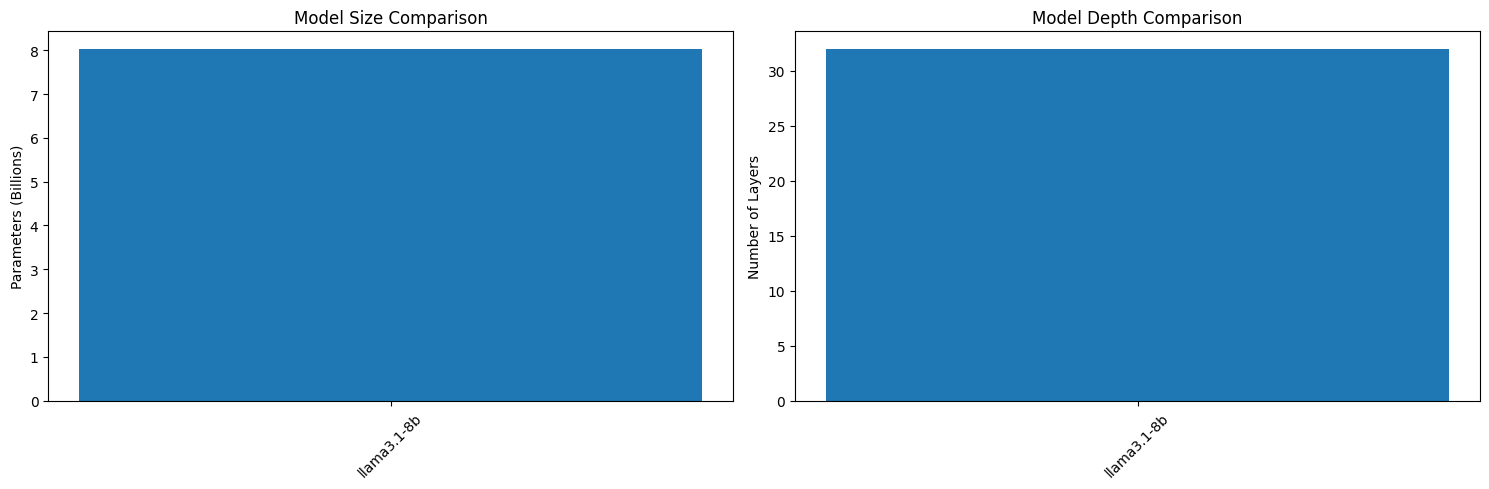


Model Comparison Table:
       path  layers parameters trainable_params  is_peft
llama3.1-8b      32      8.03B         8030.26M    False


In [28]:
# Compare model sizes and performance
if len(model_info) > 0:
    df_models_clean = pd.DataFrame([m for m in model_info if 'error' not in m])
    
    if len(df_models_clean) > 0:
        # Plot model sizes
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Parameters comparison
        model_names = [os.path.basename(p) for p in df_models_clean['path']]
        ax1.bar(model_names, df_models_clean['parameters'] / 1e9)
        ax1.set_ylabel('Parameters (Billions)')
        ax1.set_title('Model Size Comparison')
        ax1.tick_params(axis='x', rotation=45)
        
        # Layers comparison
        ax2.bar(model_names, df_models_clean['layers'])
        ax2.set_ylabel('Number of Layers')
        ax2.set_title('Model Depth Comparison')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("\nModel Comparison Table:")
        comparison_df = df_models_clean[['path', 'layers', 'parameters', 'trainable_params', 'is_peft']].copy()
        comparison_df['path'] = comparison_df['path'].apply(lambda x: os.path.basename(x))
        comparison_df['parameters'] = comparison_df['parameters'].apply(lambda x: f"{x/1e9:.2f}B")
        comparison_df['trainable_params'] = comparison_df['trainable_params'].apply(lambda x: f"{x/1e6:.2f}M")
        print(comparison_df.to_string(index=False))

## Export Results

In [29]:
# Save results to CSV
output_dir = "analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Save perplexity data
if len(ppl_data) > 0:
    ppl_data.to_csv(f"{output_dir}/perplexity_results.csv", index=False)
    print(f"Perplexity data saved to {output_dir}/perplexity_results.csv")

# Save model information
if len(model_info) > 0:
    pd.DataFrame(model_info).to_csv(f"{output_dir}/model_info.csv", index=False)
    print(f"Model information saved to {output_dir}/model_info.csv")

print("\nAnalysis complete!")

Perplexity data saved to analysis_results/perplexity_results.csv
Model information saved to analysis_results/model_info.csv

Analysis complete!
